In [1]:
import os
import os.path as osp
import json
import numpy as np
import torchmetrics
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
import torch

current_dir = os.getcwd()
ROOT_PATH = os.path.dirname(current_dir)
DATA_PATH = ROOT_PATH + '/DATA'
import sys
sys.path.append(ROOT_PATH)

from data import get_data, get_expert_data
from utils.utils import index_to_mask, pred_fn, Dict, setup_seed

def get_data_conf(_dataset):
    GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../conf")
    _data_conf = dict(compose(overrides=[f"+dataset={_dataset}"]).dataset)
    return _data_conf


def load_data(_data_conf):
    if hasattr(_data_conf, 'expert_id') and _data_conf.expert_id >= 0:
        return get_expert_data(root=DATA_PATH+'/pyg', **_data_conf)[0]
    else:
        return get_data(root=DATA_PATH+'/pyg', **_data_conf)[0]


def convert_mask(_data):
    _train_mask = index_to_mask(_data.train_mask, size=_data.num_nodes).t()
    _val_mask = index_to_mask(_data.val_mask, size=_data.num_nodes).t()
    _test_mask = index_to_mask(_data.test_mask, size=_data.num_nodes).t()
    if _train_mask.dim() == 1:
        _train_mask = _train_mask.unsqueeze(0)
        _val_mask = _val_mask.unsqueeze(0)
        _test_mask = _test_mask.unsqueeze(0)
    return _train_mask, _val_mask, _test_mask


def get_expert_masks(_eid, _data_conf, _num_experts, _group, _frac):
    _data_conf = Dict(_data_conf.copy())
    if 'FilterTest' in _group:
        _group = _group.removesuffix('FilterTest')
        _data_conf.use_test = False
    _data_conf.group = _group
    _data_conf.num_experts = _num_experts
    _data_conf.fraction = _frac
    _data_conf.expert_id = _eid
    expert_data = load_data(_data_conf)
    return expert_data.expert_val_masks.t().cpu(), expert_data.expert_test_masks.t().cpu()




## load logit file names

In [2]:
from collections import defaultdict

conf_dict = {
    "amazon_ratings": {},
    "flickr": {},
    "penn94": {},
    "pubmed": {},
    "arxiv": {},
    "chameleon": {},
    "squirrel": {},
    "actor": {},
    "wikics": {},
    "computers": {},
}
groups = ["homophily", "intra_class_degree", "intra_class_neighborhood_feature_similarity",
          "intra_class_neighborhood_label_similarity", "pagerank", "clustering_coef",
          "max_neighbor_label_ratio", "neighbor_label_entropy"]

logit_dir = "/home/yuxin/Projects/gnn-moe/processed/trial_ft_domain_experts/logit"
logit_files = set(os.listdir(logit_dir)) 
# logit_files = [
#     d for d in os.listdir(logit_dir)
#     if os.path.isdir(os.path.join(logit_dir, d)) and "amazon_ratings" in d
# ]
print(f"Found {len(logit_files)} logit files in {logit_dir}")
best_lr_path = "/home/yuxin/Projects/gnn-moe/processed/trial_ft_domain_experts/logit/best_lr.json"
with open(best_lr_path, "r") as f:
    best_lrs = json.load(f)

to_exctract = []
for group in groups:
    for dataset in conf_dict.keys():
        to_exctract.append([dataset, group])

experts = [0, 1]

for dataset, metric in to_exctract:
    for logit_file in logit_files:
        for expert in experts:
            if f"-eid-{expert}" not in logit_file:
                continue
            if dataset not in logit_file:
                continue
            if metric not in logit_file:
                continue
            best_lr = best_lrs[metric][f"{dataset}_exp{expert}"]
            if f"ftlr{best_lr}" not in logit_file:
                continue
            metric_str = f"{metric}-0.5-2"
            if metric_str not in conf_dict[dataset]:
                conf_dict[dataset][metric_str] = {}
            if osp.exists(osp.join(logit_dir, logit_file)):
                conf_dict[dataset][metric_str][f"GCN-{expert}"] = osp.join(logit_dir, logit_file)
                # print(f"Extracted {dataset}_{metric} from {logit_file}")

# Directory containing the baseline logit files
logit_dir = "/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit"


# List all files
for filename in os.listdir(logit_dir):
    if filename.endswith(".pt"):
        # Extract dataset name (before first '_GCN' or '_')
        if "_GCN" in filename:
            dataset = filename.split("_GCN")[0]
        else:
            dataset = filename.split("_")[0]
        if "-undir" in filename:
            dataset = filename.split("-undir")[0]

        # Save path under "full" config
        if dataset not in conf_dict:
            print (f"Dataset {dataset} not found in conf_dict, skipping file {filename}")
            continue
        if dataset == "arxiv":
            conf_dict[dataset]["full"] = "/home/yuxin/Projects/gnn-moe/processed/trial_GCN_baseline/logit/arxiv_GCN-dropout0.2-conv3.pt"
        else:
            conf_dict[dataset]["full"] = os.path.join(logit_dir, filename)
        print(conf_dict[dataset]["full"])


Found 1209 logit files in /home/yuxin/Projects/gnn-moe/processed/trial_ft_domain_experts/logit
Dataset amazon not found in conf_dict, skipping file amazon_ratings_GAT-jkLAST-resSUM-dropout0.5-init1-conv3.pt
/home/yuxin/Projects/gnn-moe/processed/trial_GCN_baseline/logit/arxiv_GCN-dropout0.2-conv3.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/wikics_GCN-jkATTN-dropout0.7-init1-conv2.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/penn94_GCN-dropout0.5-conv2.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/penn94_GAT-dropout0.5-conv3.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/computers_GCN-jkATTN-dropout0.6-dropedge0.1-init1-conv3.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/computers_GAT-jkATTN-dropout0.4-dropedge0.5-init1-conv2.pt
/home/yuxin/Projects/gnn-moe/processed/trial_baseline_seed_33/logit/flickr_GCN-resCAT-dropout0.5-conv4.pt
/home/yuxin/Projects/gnn-moe/

## Collect Expert logits to be ensembled

In [3]:
# group, frac, num_experts = 'homophily', 0.5, 2
# group, frac, num_experts = 'intra_class_neighborhood_feature_cos_similarity_norm', 0.5, 2
# group, frac, num_experts = 'random', 0.5, 2
# group, frac, num_experts = 'homophily', 0.8, 2
frac, num_experts = 0.5, 2
group1 = ['homophily', 'intra_class_degree', 'intra_class_neighborhood_feature_similarity', 'intra_class_neighborhood_label_similarity']
group2 = ['homophily', 'pagerank', 'clustering_coef', 'max_neighbor_label_ratio']
group3 = ['pagerank', 'clustering_coef', 'max_neighbor_label_ratio', 'neighbor_label_entropy']
all_groups = set(group1 + group2 + group3)
dataset = 'pubmed'

setup_seed(0)

data_conf = get_data_conf(dataset)
data = load_data(data_conf)
train_mask, val_mask, test_mask = convert_mask(data)
r = train_mask.size(0)

expert_val_masks, expert_test_masks = [], []
for eid in range(num_experts):
    _e_val_mk, _e_test_mk = get_expert_masks(eid, data_conf, num_experts, group, frac)
    expert_val_masks.append(_e_val_mk)
    expert_test_masks.append(_e_test_mk)

In [9]:
model = 'GCN'
expert_logits = {}
for dataset in conf_dict.keys():
    if dataset not in expert_logits:
        expert_logits[dataset] = {}
    for idx, groups in enumerate([group1, group2, group3]):
        if idx not in expert_logits[dataset].keys():
            expert_logits[dataset][idx] = [torch.load(conf_dict[dataset]['full'], weights_only=True)]
        for group in groups:
            for eid in range(num_experts):
                metric_str = f"{group}-{frac}-{num_experts}"
                if metric_str not in conf_dict[dataset]:
                    print(f"Metric {metric_str} not found in conf_dict for dataset {dataset}. Skipping.")
                    continue
                # print(f"Processing group: {group}, fraction: {frac}, num_experts: {num_experts}, model: {model}")
                model_logit_path = conf_dict[dataset][f'{group}-{frac}-{num_experts}'][f'{model}-{eid}']
                expert_logits[dataset][idx].append(torch.load(model_logit_path, weights_only=True))

In [10]:
print(dataset, idx)
expert_logits["squirrel"][idx][-1].shape

computers 2


torch.Size([10, 2223, 5])

## Compute error inconsistency and plot

/home/yuxin/anaconda3/envs/gnnmoe/lib/python3.11/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = tor

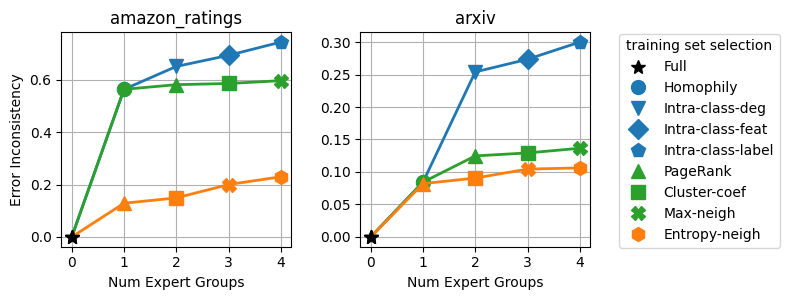

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Precompute number of datasets
expert_logits_to_show = {}
expert_logits_to_show["amazon_ratings"] = expert_logits["amazon_ratings"]
expert_logits_to_show["arxiv"] = expert_logits["arxiv"]

n_datasets = len(expert_logits_to_show)
fig, axs = plt.subplots(1, n_datasets, figsize=(3.4 * n_datasets, 3.1
                                                ), sharey=False)

# Global legend registry
global_custom_legend = {}

for ax, dataset in zip(axs, expert_logits_to_show.keys()):
    data_conf = get_data_conf(dataset)
    data = load_data(data_conf)
    train_mask, val_mask, test_mask = convert_mask(data)
    r = train_mask.size(0)

    expert_val_masks, expert_test_masks = [], []
    for eid in range(num_experts):
        _e_val_mk, _e_test_mk = get_expert_masks(eid, data_conf, num_experts, group, frac)
        expert_val_masks.append(_e_val_mk)
        expert_test_masks.append(_e_test_mk)

    eis = {}
    for group_idx in expert_logits_to_show[dataset].keys():
        eis[group_idx] = []
        total_expert_logits = torch.stack(expert_logits_to_show[dataset][group_idx], dim=0)
        for i in range(5):
            _expert_logits = total_expert_logits[0:i * 2 + 1]
            if _expert_logits.shape[-1] == 1:
                _accs = (_expert_logits > 0).squeeze(-1) == data.y
            else:
                _accs = _expert_logits.argmax(dim=-1) == data.y
            _accs = _accs.float()

            all_correct = _accs.mean(dim=0) == 1
            all_wrong = _accs.mean(dim=0) == 0
            err_inconsis_mask = ~(all_wrong | all_correct)

            err_inc_arr = []
            for run in range(10):
                err_inc = err_inconsis_mask[run][test_mask[run % r]].float().mean()
                err_inc_arr.append(err_inc)
            eis[group_idx].append(np.mean(err_inc_arr))

    group_labels = {
        0: ['Homophily', 'Intra-class-deg', 'Intra-class-feat', 'Intra-class-label'],
        1: ['Homophily', 'PageRank', 'Cluster-coef', 'Max-neigh'],
        2: ['PageRank', 'Cluster-coef', 'Max-neigh', 'Entropy-neigh']
    }

    group_markers = {
        'Homophily': 'o',
        'Intra-class-deg': 'v',
        'Intra-class-feat': 'D',
        'Intra-class-label': 'p',
        'PageRank': '^',
        'Cluster-coef': 's',
        'Max-neigh': 'X',
        'Entropy-neigh': 'h'
    }

    line_colors = {
        0: '#1f77b4',
        1: '#2ca02c',
        2: '#ff7f0e',
    }

    x = np.arange(5)
    for line_idx, values in eis.items():
        ax.plot(x, values, color=line_colors[line_idx], linewidth=2)

        for xi, yi in enumerate(values):
            if xi == 0:
                handle = ax.plot(
                    xi, yi, marker='*', color='black', markersize=10, linestyle='None', label='Full'
                )[0]
                global_custom_legend['Full'] = handle
            elif xi - 1 < len(group_labels[line_idx]):
                group_name = group_labels[line_idx][xi - 1]
                marker = group_markers[group_name]
                handle = ax.plot(
                    xi, yi, marker=marker, color=line_colors[line_idx], markersize=10,
                    linestyle='None', label=group_name
                )[0]
                if group_name not in global_custom_legend:
                    global_custom_legend[group_name] = handle

    ax.set_title(dataset)
    ax.set_xlabel("Num Expert Groups")
    ax.set_xticks(x)
    ax.grid(True)

axs[0].set_ylabel("Error Inconsistency")

fig.legend(
    global_custom_legend.values(), global_custom_legend.keys(),
    title="training set selection",
    loc='center left', bbox_to_anchor=(1.01, 0.53), ncol=1
)

plt.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.3)
fig_dir = "/home/yuxin/Projects/gnn-moe/figs/"
if not osp.exists(fig_dir):
    os.makedirs(fig_dir)
plt.savefig(
    "/home/yuxin/Projects/gnn-moe/figs/fig9.png",
    bbox_inches='tight', dpi=300
)

/home/yuxin/anaconda3/envs/gnnmoe/lib/python3.11/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([DataEdgeAttr])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/home/yuxin/anaconda3/envs/gnnmoe/lib/python3.11/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be 

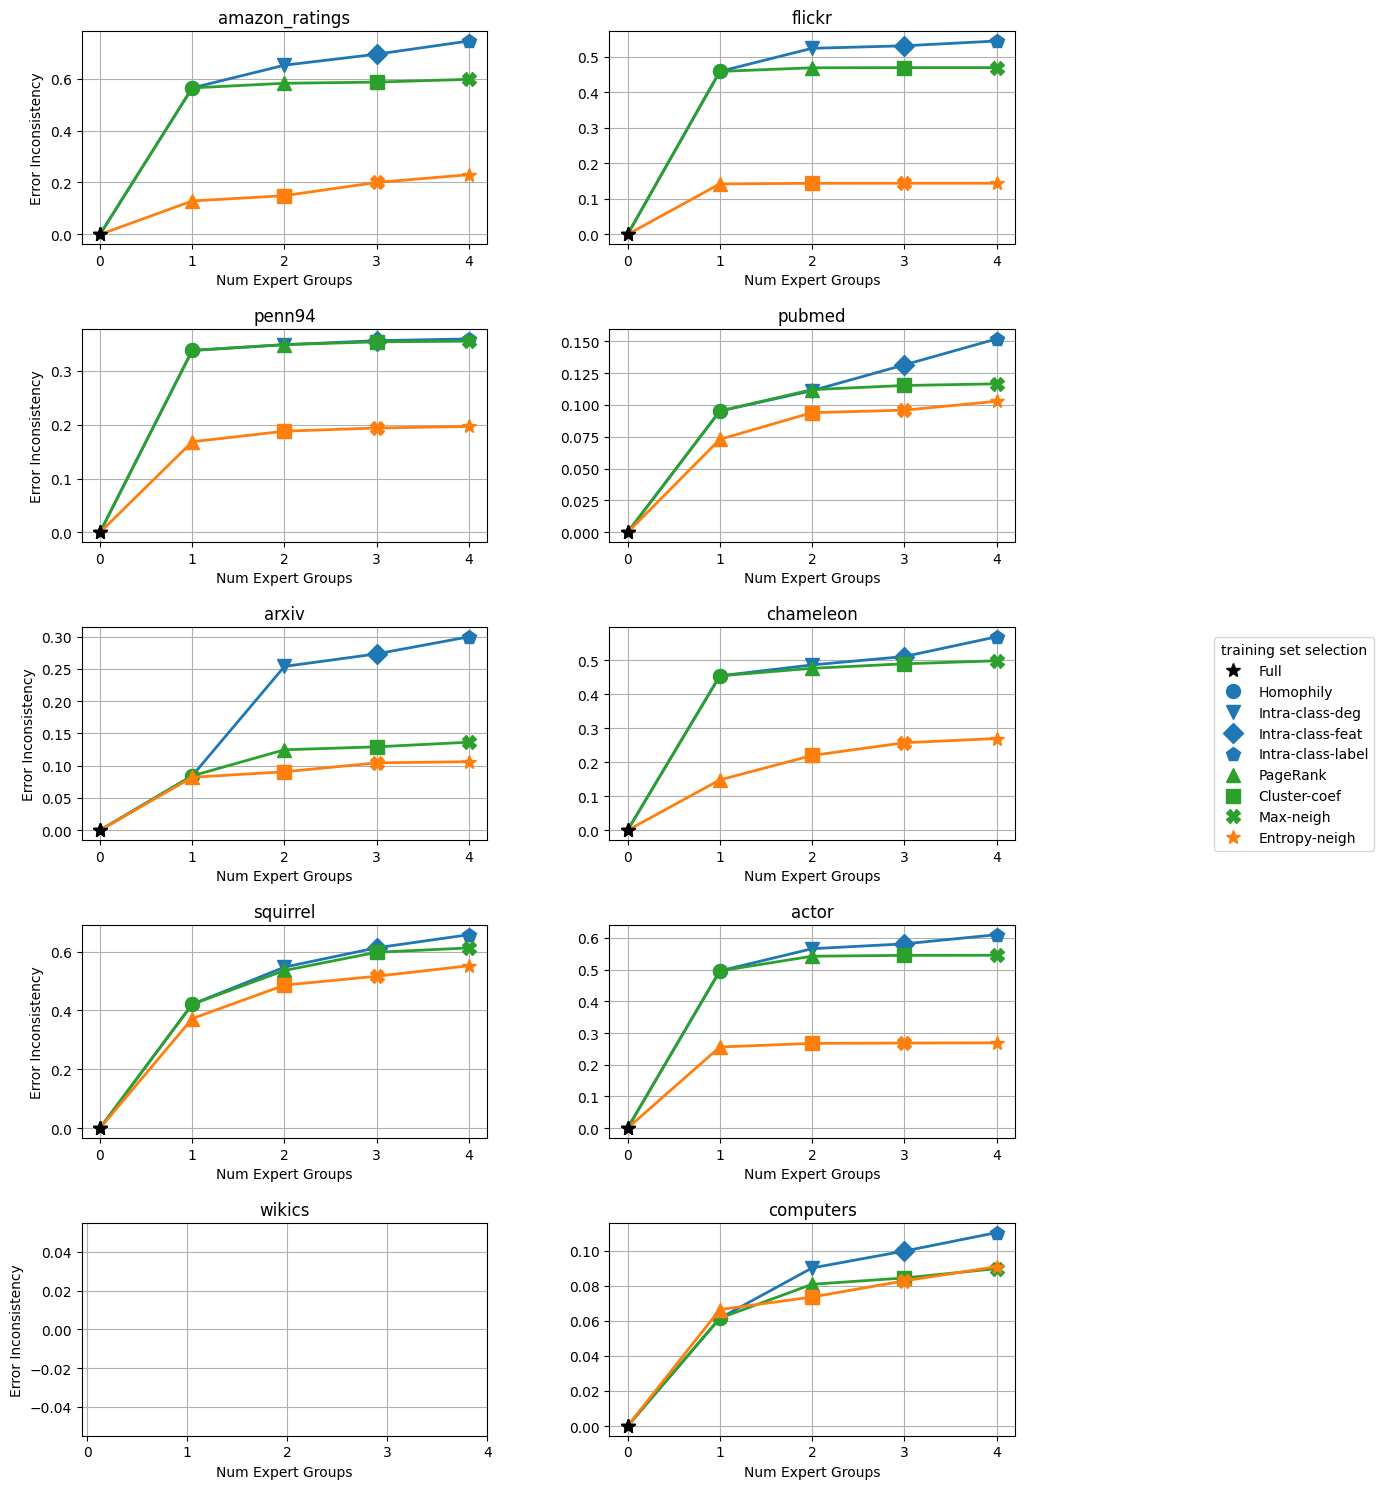

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import math

expert_logits_to_show = expert_logits
n_datasets = len(expert_logits_to_show)
ncols = 2
nrows = math.ceil(n_datasets / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3 * nrows), sharey=False)
axs = axs.flatten()

global_custom_legend = {}

for ax, dataset in zip(axs, expert_logits_to_show.keys()):
    data_conf = get_data_conf(dataset)
    data = load_data(data_conf)
    train_mask, val_mask, test_mask = convert_mask(data)
    r = train_mask.size(0)

    expert_val_masks, expert_test_masks = [], []
    for eid in range(num_experts):
        _e_val_mk, _e_test_mk = get_expert_masks(eid, data_conf, num_experts, group, frac)
        expert_val_masks.append(_e_val_mk)
        expert_test_masks.append(_e_test_mk)

    eis = {}
    for group_idx in expert_logits_to_show[dataset].keys():
        eis[group_idx] = []
        total_expert_logits = torch.stack(expert_logits_to_show[dataset][group_idx], dim=0)
        for i in range(5):
            _expert_logits = total_expert_logits[0:i * 2 + 1]
            if _expert_logits.shape[-1] == 1:
                _accs = (_expert_logits > 0).squeeze(-1) == data.y
            else:
                _accs = _expert_logits.argmax(dim=-1) == data.y
            _accs = _accs.float()

            all_correct = _accs.mean(dim=0) == 1
            all_wrong = _accs.mean(dim=0) == 0
            err_inconsis_mask = ~(all_wrong | all_correct)

            err_inc_arr = []
            for run in range(10):
                err_inc = err_inconsis_mask[run][test_mask[run % r]].float().mean()
                err_inc_arr.append(err_inc)
            eis[group_idx].append(np.mean(err_inc_arr))

    group_labels = {
        0: ['Homophily', 'Intra-class-deg', 'Intra-class-feat', 'Intra-class-label'],
        1: ['Homophily', 'PageRank', 'Cluster-coef', 'Max-neigh'],
        2: ['PageRank', 'Cluster-coef', 'Max-neigh', 'Entropy-neigh']
    }

    group_markers = {
        'Homophily': 'o',
        'Intra-class-deg': 'v',
        'Intra-class-feat': 'D',
        'Intra-class-label': 'p',
        'PageRank': '^',
        'Cluster-coef': 's',
        'Max-neigh': 'X',
        'Entropy-neigh': '*'
    }

    line_colors = {
        0: '#1f77b4',
        1: '#2ca02c',
        2: '#ff7f0e',
    }

    x = np.arange(5)
    for line_idx, values in eis.items():
        ax.plot(x, values, color=line_colors[line_idx], linewidth=2)

        for xi, yi in enumerate(values):
            if xi == 0:
                handle = ax.plot(
                    xi, yi, marker='*', color='black', markersize=10, linestyle='None', label='Full'
                )[0]
                global_custom_legend['Full'] = handle
            elif xi - 1 < len(group_labels[line_idx]):
                group_name = group_labels[line_idx][xi - 1]
                marker = group_markers[group_name]
                handle = ax.plot(
                    xi, yi, marker=marker, color=line_colors[line_idx], markersize=10,
                    linestyle='None', label=group_name
                )[0]
                if group_name not in global_custom_legend:
                    global_custom_legend[group_name] = handle

    ax.set_title(dataset)
    ax.set_xlabel("Num Expert Groups")
    ax.set_xticks(x)
    ax.grid(True)

# Set shared y-label only on the first column of plots
for row in range(nrows):
    axs[row * ncols].set_ylabel("Error Inconsistency")

# Hide unused subplots if any
for ax in axs[n_datasets:]:
    ax.axis("off")

# Place shared legend to the right
fig.legend(
    global_custom_legend.values(), global_custom_legend.keys(),
    title="training set selection",
    loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1
)

plt.tight_layout()
plt.subplots_adjust(right=0.85, hspace=0.4, wspace=0.3)
plt.show()


In [13]:
for alpha in np.arange(0., 1.1, 0.1):
    val_acc, test_acc = [], []
    expert_val_accs, expert_test_accs = [[] for _ in range(num_experts) ], [[] for _ in range(num_experts)]
    for run in range(10):
        logit = expert_logits[0][run] * alpha + expert_logits[1][run] * (1-alpha)

        y_hat, y = pred_fn(logit, data.y)
        all_acc = y_hat == y

        test_acc.append(all_acc[test_mask[run%r]].float().mean().item())
        val_acc.append(all_acc[val_mask[run%r]].float().mean().item())

        for eid in range(num_experts):
            expert_val_accs[eid].append(all_acc[expert_val_masks[eid][run%r]].float().mean().item())
            expert_test_accs[eid].append(all_acc[expert_test_masks[eid][run%r]].float().mean().item())

    print(f'Alpha: {alpha:.1f}, '
          f'Val ACC: {np.mean(val_acc)*100:.2f} ±{np.std(val_acc)*100:.2f}, '
          f'Test ACC: {np.mean(test_acc)*100:.2f} ±{np.std(test_acc)*100:.2f}')

    for eid in range(num_experts):
        group_val = np.array(expert_val_accs[eid])
        group_test = np.array(expert_test_accs[eid])
        print(f'[{eid}] '
              # f'Val: {np.mean(group_val) * 100:.2f} ±{np.std(group_val) * 100:.2f} '
              f'Test: {np.mean(group_test) * 100:.2f} ±{np.std(group_test) * 100:.2f}', end='\t')

    print('\n')

Alpha: 0.0, Val ACC: 48.75 ±0.46, Test ACC: 48.10 ±0.46
[0] Test: 47.96 ±0.80	[1] Test: 48.23 ±0.51	

Alpha: 0.1, Val ACC: 49.97 ±0.57, Test ACC: 49.46 ±0.47
[0] Test: 49.36 ±0.78	[1] Test: 49.57 ±0.54	

Alpha: 0.2, Val ACC: 51.09 ±0.55, Test ACC: 50.74 ±0.37
[0] Test: 50.80 ±0.85	[1] Test: 50.69 ±0.65	

Alpha: 0.3, Val ACC: 51.88 ±0.52, Test ACC: 51.55 ±0.36
[0] Test: 51.50 ±0.77	[1] Test: 51.61 ±0.79	

Alpha: 0.4, Val ACC: 52.17 ±0.50, Test ACC: 52.08 ±0.39
[0] Test: 52.05 ±0.81	[1] Test: 52.11 ±0.69	

Alpha: 0.5, Val ACC: 52.15 ±0.41, Test ACC: 52.28 ±0.49
[0] Test: 52.39 ±0.88	[1] Test: 52.19 ±0.83	

Alpha: 0.6, Val ACC: 51.81 ±0.51, Test ACC: 51.85 ±0.60
[0] Test: 51.96 ±0.70	[1] Test: 51.74 ±1.06	

Alpha: 0.7, Val ACC: 51.26 ±0.56, Test ACC: 51.15 ±0.65
[0] Test: 51.23 ±0.58	[1] Test: 51.08 ±1.07	

Alpha: 0.8, Val ACC: 50.46 ±0.43, Test ACC: 50.17 ±0.63
[0] Test: 50.12 ±0.55	[1] Test: 50.21 ±1.09	

Alpha: 0.9, Val ACC: 49.75 ±0.28, Test ACC: 49.10 ±0.57
[0] Test: 49.13 ±0.35	[1] 

### Mix with full

In [5]:
model_arch = conf_dict[dataset][f'full'][f'{model}']
file_name = osp.join(RES_PATH, f'logit/{dataset}_{model}-{model_arch}-conv{2}.pt')
full_logit = torch.load(file_name, weights_only=True)

expert_alpha = 0.5

for alpha in np.arange(0., 1.1, 0.1):
    val_acc, test_acc = [], []
    expert_val_accs, expert_test_accs = [[] for _ in range(num_experts) ], [[] for _ in range(num_experts)]
    for run in range(10):
        logit = expert_logits[0][run] * expert_alpha + expert_logits[1][run] * (1-expert_alpha)

        logit = logit * alpha + full_logit[run] * (1-alpha)

        y_hat, y = pred_fn(logit, data.y)
        all_acc = y_hat == y

        test_acc.append(all_acc[test_mask[run%r]].float().mean().item())
        val_acc.append(all_acc[val_mask[run%r]].float().mean().item())

        for eid in range(num_experts):
            expert_val_accs[eid].append(all_acc[expert_val_masks[eid][run%r]].float().mean().item())
            expert_test_accs[eid].append(all_acc[expert_test_masks[eid][run%r]].float().mean().item())

    print(f'Alpha: {alpha:.1f}, '
          f'Val ACC: {np.mean(val_acc)*100:.2f} ±{np.std(val_acc)*100:.2f}, '
          f'Test ACC: {np.mean(test_acc)*100:.2f} ±{np.std(test_acc)*100:.2f}')

    for eid in range(num_experts):
        group_val = np.array(expert_val_accs[eid])
        group_test = np.array(expert_test_accs[eid])
        print(f'[{eid}] '
              # f'Val: {np.mean(group_val) * 100:.2f} ±{np.std(group_val) * 100:.2f} '
              f'Test: {np.mean(group_test) * 100:.2f} ±{np.std(group_test) * 100:.2f}', end='\t')

    print('\n')

Alpha: 0.0, Val ACC: 54.84 ±0.43, Test ACC: 54.10 ±0.55
[0] Test: 54.00 ±0.85	[1] Test: 54.21 ±0.82	

Alpha: 0.1, Val ACC: 54.88 ±0.53, Test ACC: 54.38 ±0.53
[0] Test: 54.34 ±0.81	[1] Test: 54.42 ±0.87	

Alpha: 0.2, Val ACC: 54.81 ±0.47, Test ACC: 54.46 ±0.48
[0] Test: 54.39 ±0.78	[1] Test: 54.54 ±0.86	

Alpha: 0.3, Val ACC: 54.79 ±0.52, Test ACC: 54.54 ±0.45
[0] Test: 54.45 ±0.80	[1] Test: 54.64 ±0.85	

Alpha: 0.4, Val ACC: 54.58 ±0.47, Test ACC: 54.39 ±0.38
[0] Test: 54.40 ±0.75	[1] Test: 54.37 ±0.94	

Alpha: 0.5, Val ACC: 54.30 ±0.44, Test ACC: 54.24 ±0.39
[0] Test: 54.23 ±0.74	[1] Test: 54.25 ±0.93	

Alpha: 0.6, Val ACC: 53.84 ±0.41, Test ACC: 53.88 ±0.44
[0] Test: 53.87 ±0.76	[1] Test: 53.90 ±0.97	

Alpha: 0.7, Val ACC: 53.51 ±0.41, Test ACC: 53.55 ±0.48
[0] Test: 53.56 ±0.81	[1] Test: 53.54 ±0.88	

Alpha: 0.8, Val ACC: 53.09 ±0.38, Test ACC: 53.14 ±0.51
[0] Test: 53.21 ±0.84	[1] Test: 53.06 ±0.88	

Alpha: 0.9, Val ACC: 52.62 ±0.39, Test ACC: 52.73 ±0.50
[0] Test: 52.80 ±0.86	[1] 

## Weighted Model Ensemble (Not Useful)

In [33]:
def calculate_accs(_model_expert_logits, _models, _weights):
    assert len(_models) == len(_weights[0])
    _num_experts = len(_weights)

    _val_acc, _test_acc = [], []
    _expert_val_accs, _expert_test_accs = [[] for _ in range(_num_experts)], [[] for _ in range(_num_experts)]
    for _run in range(10):
        _total_logits = torch.zeros_like(model_expert_logits[_models[0]][0][_run])
        for i, _model in enumerate(_models):
            for _eid in range(_num_experts):
                _total_logits += _model_expert_logits[_model][_eid][_run] * _weights[_eid][i]

        _y_hat, _y = pred_fn(_total_logits, data.y)
        _all_acc = _y_hat == _y

        _test_acc.append(_all_acc[test_mask[_run%r]].float().mean().item())
        _val_acc.append(_all_acc[val_mask[_run%r]].float().mean().item())

        for _eid in range(_num_experts):
            _expert_val_accs[_eid].append(_all_acc[expert_val_masks[_eid][_run%r]].float().mean().item())
            _expert_test_accs[_eid].append(_all_acc[expert_test_masks[_eid][_run%r]].float().mean().item())

    return _val_acc, _test_acc, _expert_val_accs, _expert_test_accs


# models = ['GAT', 'GCNII', 'MIXHOP']
# models = ['GCNII', 'MIXHOP']
# models = ['GCNII', 'GAT']
models = ['GAT', 'MIXHOP']
# models = ['GCN', 'MIXHOP']
best_val = best_test = 0.0
best_result_str = ''

for alpha_0 in np.arange(0., 1.1, 0.1):
    for alpha_1 in np.arange(0., 1.1, 0.1):
        for beta_0 in np.arange(0., 1.1, 0.1):
            for beta_1 in np.arange(0., 1.1, 0.1):
                # for gamma_0 in np.arange(0., 1.1, 0.1):
                    # for gamma_1 in np.arange(0., 1.1, 0.1):

                        # weights = [[alpha_0, beta_0, gamma_0], [alpha_1, beta_1, gamma_1]]
                weights = [[alpha_0, beta_0], [alpha_1, beta_1]]

                val_acc, test_acc, expert_val_accs, expert_test_accs = calculate_accs(model_expert_logits, models, weights)

                result_str = (f'alpha_0: {alpha_0:.1f}, alpha_1: {alpha_1:.1f}'
                              f'beta_0: {beta_0:.1f}, beta_1: {beta_1:.1f}'
                              # f'gamma_0: {gamma_0:.1f}, gamma_1: {gamma_1:.1f}'
                              f'\nVal ACC: {np.mean(val_acc)*100:.2f} ±{np.std(val_acc)*100:.2f}, '
                              f'Test ACC: {np.mean(test_acc)*100:.2f} ±{np.std(test_acc)*100:.2f}\n')
                for eid in range(num_experts):
                    group_val = np.array(expert_val_accs[eid])
                    group_test = np.array(expert_test_accs[eid])
                    result_str += (f'[{eid}] '
                                   # f'Val: {np.mean(group_val) * 100:.2f} ±{np.std(group_val) * 100:.2f} '
                                   f'Test: {np.mean(group_test) * 100:.2f} ±{np.std(group_test) * 100:.2f} ')

                # print(result_str+'\n')

                if np.mean(val_acc) > best_val:
                # if np.mean(test_acc) > test_val:
                    best_val = np.mean(val_acc)
                    best_test = np.mean(test_acc)
                    best_result_str = result_str

print('-----------------------------')
print(best_result_str)

-----------------------------
alpha_0: 0.5, alpha_1: 0.4beta_0: 0.5, beta_1: 0.9
Val ACC: 56.04 ±0.31, Test ACC: 55.88 ±0.53
[0] Test: 28.09 ±1.12 [1] Test: 83.55 ±1.48 


## Hop (+Model) Ensemble

In [13]:
min_hop, max_hop = 1, 3
model = 'GCNII'

hop_expert_logits = []
for eid in range(num_experts):
    hop_logits = []
    for hop in range(min_hop, max_hop+1):
        if min_hop == 0:
            model_arch = conf_dict[dataset][f'{group}-{frac}-{num_experts}'][f'MLP-{eid}']
            file_name = osp.join(RES_PATH, f'logit/{dataset}-group-{group}-frac-{frac}-eid-{eid}-{num_experts}_MLP-{model_arch}-conv{3}.pt')
        else:
            model_arch = conf_dict[dataset][f'{group}-{frac}-{num_experts}'][f'{model}-{eid}']
            file_name = osp.join(RES_PATH, f'logit/{dataset}-group-{group}-frac-{frac}-eid-{eid}-{num_experts}_{model}-{model_arch}-conv{hop}.pt')
        hop_logits.append(torch.load(file_name, weights_only=True))
    hop_expert_logits.append(torch.stack(hop_logits, dim=1))

In [14]:
model_hop_expert_logits = []
for eid in range(num_experts):
    hop_expert_logits = []
    for _model in ['GCNII', 'MIXHOP']:
        hop_logits = []
        for hop in range(min_hop, max_hop+1):
            if min_hop == 0:
                model_arch = conf_dict[dataset][f'{group}-{frac}-{num_experts}'][f'MLP-{eid}']
                file_name = osp.join(RES_PATH, f'logit/{dataset}-group-{group}-frac-{frac}-eid-{eid}-{num_experts}_MLP-{model_arch}-conv{3}.pt')
            else:
                model_arch = conf_dict[dataset][f'{group}-{frac}-{num_experts}'][f'{_model}-{eid}']
                file_name = osp.join(RES_PATH, f'logit/{dataset}-group-{group}-frac-{frac}-eid-{eid}-{num_experts}_{_model}-{model_arch}-conv{hop}.pt')
            hop_logits.append(torch.load(file_name, weights_only=True))
        hop_expert_logits.append(torch.stack(hop_logits, dim=1))
    model_hop_expert_logits.append(torch.stack(hop_expert_logits, dim=1))

In [15]:
add_model = False
# add_model = True

for alpha in np.arange(0., 1.1, 0.1):
    val_acc, test_acc = [], []
    expert_val_accs, expert_test_accs = [[] for _ in range(num_experts) ], [[] for _ in range(num_experts)]
    for run in range(10):
        if add_model:
            agg_expert_logit_0 = model_hop_expert_logits[0][run].mean(dim=0).mean(dim=0)
            agg_expert_logit_1 = model_hop_expert_logits[1][run].mean(dim=0).mean(dim=0)
        else:
            agg_expert_logit_0 = hop_expert_logits[0][run].mean(dim=0)
            agg_expert_logit_1 = hop_expert_logits[1][run].mean(dim=0)

        logit = agg_expert_logit_0 * alpha + agg_expert_logit_1 * (1-alpha)

        y_hat, y = pred_fn(logit, data.y)
        all_acc = y_hat == y

        test_acc.append(all_acc[test_mask[run%r]].float().mean().item())
        val_acc.append(all_acc[val_mask[run%r]].float().mean().item())

        for eid in range(num_experts):
            expert_val_accs[eid].append(all_acc[expert_val_masks[eid][run%r]].float().mean().item())
            expert_test_accs[eid].append(all_acc[expert_test_masks[eid][run%r]].float().mean().item())

    print(f'Alpha: {alpha:.1f}, '
          f'Val ACC: {np.mean(val_acc)*100:.2f} ±{np.std(val_acc)*100:.2f}, '
          f'Test ACC: {np.mean(test_acc)*100:.2f} ±{np.std(test_acc)*100:.2f}')

    for eid in range(num_experts):
        group_val = np.array(expert_val_accs[eid])
        group_test = np.array(expert_test_accs[eid])
        print(f'[{eid}] '
              # f'Val: {np.mean(group_val) * 100:.2f} ±{np.std(group_val) * 100:.2f} '
              f'Test: {np.mean(group_test) * 100:.2f} ±{np.std(group_test) * 100:.2f}', end='\t')

    print('\n')

Alpha: 0.0, Val ACC: 54.58 ±0.33, Test ACC: 54.50 ±0.31
[0] Test: 22.35 ±0.74	[1] Test: 86.50 ±0.69	

Alpha: 0.1, Val ACC: 54.58 ±0.33, Test ACC: 54.53 ±0.33
[0] Test: 22.31 ±0.75	[1] Test: 86.61 ±0.67	

Alpha: 0.2, Val ACC: 54.58 ±0.36, Test ACC: 54.54 ±0.34
[0] Test: 22.22 ±0.76	[1] Test: 86.71 ±0.60	

Alpha: 0.3, Val ACC: 54.60 ±0.39, Test ACC: 54.55 ±0.36
[0] Test: 22.11 ±0.75	[1] Test: 86.85 ±0.57	

Alpha: 0.4, Val ACC: 54.61 ±0.35, Test ACC: 54.61 ±0.34
[0] Test: 22.11 ±0.72	[1] Test: 86.96 ±0.58	

Alpha: 0.5, Val ACC: 54.63 ±0.33, Test ACC: 54.58 ±0.33
[0] Test: 22.00 ±0.80	[1] Test: 87.01 ±0.58	

Alpha: 0.6, Val ACC: 54.66 ±0.33, Test ACC: 54.58 ±0.36
[0] Test: 21.96 ±0.75	[1] Test: 87.04 ±0.59	

Alpha: 0.7, Val ACC: 54.63 ±0.31, Test ACC: 54.51 ±0.32
[0] Test: 21.82 ±0.69	[1] Test: 87.05 ±0.57	

Alpha: 0.8, Val ACC: 54.58 ±0.29, Test ACC: 54.51 ±0.34
[0] Test: 21.82 ±0.62	[1] Test: 87.05 ±0.60	

Alpha: 0.9, Val ACC: 54.50 ±0.30, Test ACC: 54.40 ±0.35
[0] Test: 21.75 ±0.63	[1] 